In [1]:
import keras
from keras import regularizers, optimizers
from keras import losses
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Input, Dropout, Embedding, LSTM
from keras.optimizers import RMSprop, Adam, Nadam
from keras.preprocessing import sequence

from keras.layers import Conv1D, Flatten, Activation, SpatialDropout1D
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.utils import to_categorical

import sklearn
from sklearn.preprocessing import StandardScaler, MinMaxScaler
 
from sklearn.metrics import confusion_matrix, roc_auc_score,precision_recall_curve
from sklearn.metrics import classification_report,auc

import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

import tensorflow 
import sys
print("Python: ", sys.version)

print("pandas: ", pd.__version__)
print("numpy: ", np.__version__)
print("seaborn: ", sns.__version__)
print("matplotlib: ", matplotlib.__version__)
print("sklearn: ", sklearn.__version__)
print("Keras: ", keras.__version__)
print("Tensorflow: ", tensorflow.__version__)


Using TensorFlow backend.


Python:  3.7.0 (default, Jun 28 2018, 08:04:48) [MSC v.1912 64 bit (AMD64)]
pandas:  0.23.4
numpy:  1.19.1
seaborn:  0.9.0
matplotlib:  2.2.3
sklearn:  0.19.2
Keras:  2.3.1
Tensorflow:  2.1.0


In [2]:
df=pd.read_csv("../data/ec2_cpu_utilization_77c1ca.txt", sep=",", index_col=None)
print(df.shape)
pd.options.display.max_columns = None
df.tail(5)



(4032, 2)


,timestamp,value
4027,2014-04-16 14:00:00,0.098
4028,2014-04-16 14:05:00,0.102
4029,2014-04-16 14:10:00,0.102
4030,2014-04-16 14:15:00,0.100
4031,2014-04-16 14:20:00,0.102


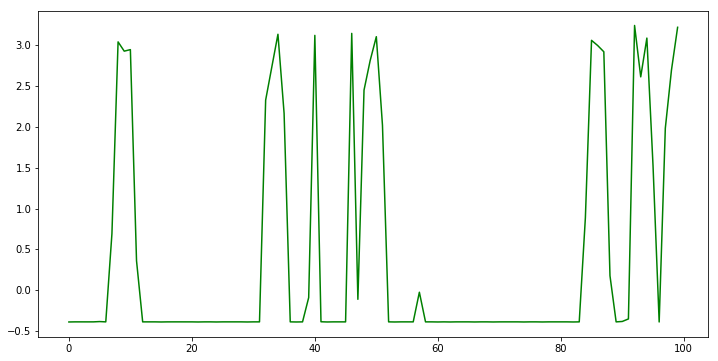

In [46]:
data= StandardScaler().fit_transform(df['value'].values.reshape(-1, 1))
plt.figure(figsize=(12,6))
plt.plot(data[0:100],color="green")

In [48]:
train=data[[data<0.5]]
train=np.array(train)
timesquence=20
trim=len(train)%timesquence
train=train[:len(train)-trim]
train.shape=(int(len(train)/timesquence),timesquence,1)
print("train",train.shape)
print(train)

train (175, 20, 1)
[[[-0.38811743]
  [-0.38685468]
  [-0.38692896]
  ...
  [-0.38819171]
  [-0.38700324]
  [-0.38685468]]

 [[-0.38811743]
  [-0.38692896]
  [-0.38685468]
  ...
  [-0.11090598]
  [-0.38685468]
  [-0.38819171]]

 [[-0.38685468]
  [-0.38692896]
  [-0.38692896]
  ...
  [-0.38685468]
  [-0.38692896]
  [-0.38685468]]

 ...

 [[ 0.48035961]
  [ 0.28448431]
  [-0.36204529]
  ...
  [-0.38685468]
  [-0.38811743]
  [-0.38692896]]

 [[-0.38692896]
  [-0.38685468]
  [-0.38685468]
  ...
  [-0.38685468]
  [ 0.36797458]
  [ 0.12292619]]

 [[-0.33849866]
  [-0.37081028]
  [-0.38692896]
  ...
  [-0.38826599]
  [-0.38685468]
  [-0.38700324]]]


F:\anaconda\anac\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  """Entry point for launching an IPython kernel.


In [50]:
test=data[0:1000]
test_label=[]
for i in range(len(test)):
    if(test[i]>0.4 ):
        test_label.append(1)
    else:
        test_label.append(0)
            
print(len(test_label))
test=np.array(test)
trim=len(test)%timesquence
test_label=test_label[:len(test)-trim]
test=test[:len(test)-trim]
test.shape=(int(len(test)/timesquence),timesquence,1)
print("test",test.shape)

1000
test (50, 20, 1)


In [198]:
from keras.layers import  Lambda
n_filters = 32 
filter_width = 2
dilation_rates = [2**i for i in range(4)] 
# define an input history series and pass it through a stack of dilated causal convolutions. 
history_seq = Input(shape=(None, 1))
x = history_seq
for dilation_rate in dilation_rates:
    x = Conv1D(filters=n_filters,
               kernel_size=filter_width, 
              kernel_regularizer=regularizers.l2(0.02),
               padding='causal',
               dilation_rate=dilation_rate,activation='relu')(x)

x = Dense(128, activation='relu')(x)
x = Dropout(.2)(x)
x = Dense(1)(x)
# extract the last 14 time steps as the training target
def slice(x, seq_length):
    return x[:,-seq_length:,:]
pred_seq_train = Lambda(slice, arguments={'seq_length':timesquence})(x)

TCN = Model(history_seq, pred_seq_train)
TCN.compile(optimizer=optimizers.Adam(), loss='mean_absolute_error')
TCN.summary()

Model: "model_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_29 (InputLayer)        (None, None, 1)           0         
_________________________________________________________________
conv1d_126 (Conv1D)          (None, None, 32)          96        
_________________________________________________________________
conv1d_127 (Conv1D)          (None, None, 32)          2080      
_________________________________________________________________
conv1d_128 (Conv1D)          (None, None, 32)          2080      
_________________________________________________________________
conv1d_129 (Conv1D)          (None, None, 32)          2080      
_________________________________________________________________
dense_57 (Dense)             (None, None, 128)         4224      
_________________________________________________________________
dropout_29 (Dropout)         (None, None, 128)         0  

In [199]:
from keras.callbacks import TensorBoard
tensorboard=tensorflow.keras.callbacks.TensorBoard(histogram_freq=1)
history=TCN.fit(train, train,
          batch_size=2**10,#10
           epochs=131,#133     
            validation_data=(test, test))
         # callbacks = [tensorboard])


Train on 175 samples, validate on 50 samples
Epoch 1/131
175/175 [==============================] - 4s 23ms/step - loss: 2.3334 - val_loss: 2.5838
Epoch 2/131
175/175 [==============================] - 0s 519us/step - loss: 2.3025 - val_loss: 2.5518
Epoch 3/131
175/175 [==============================] - 0s 527us/step - loss: 2.2669 - val_loss: 2.5179
Epoch 4/131
175/175 [==============================] - 0s 507us/step - loss: 2.2297 - val_loss: 2.4828
Epoch 5/131
175/175 [==============================] - 0s 542us/step - loss: 2.1904 - val_loss: 2.4470
Epoch 6/131
175/175 [==============================] - 0s 519us/step - loss: 2.1509 - val_loss: 2.4105
Epoch 7/131
175/175 [==============================] - 0s 576us/step - loss: 2.1101 - val_loss: 2.3738
Epoch 8/131
175/175 [==============================] - 0s 530us/step - loss: 2.0689 - val_loss: 2.3365
Epoch 9/131
175/175 [==============================] - 0s 530us/step - loss: 2.0272 - val_loss: 2.2984
Epoch 10/131
175/175 [=======

Epoch 80/131
175/175 [==============================] - 0s 526us/step - loss: 0.6908 - val_loss: 1.0269
Epoch 81/131
175/175 [==============================] - 0s 531us/step - loss: 0.6811 - val_loss: 1.0177
Epoch 82/131
175/175 [==============================] - 0s 543us/step - loss: 0.6714 - val_loss: 1.0081
Epoch 83/131
175/175 [==============================] - 0s 526us/step - loss: 0.6623 - val_loss: 0.9984
Epoch 84/131
175/175 [==============================] - 0s 560us/step - loss: 0.6530 - val_loss: 0.9888
Epoch 85/131
175/175 [==============================] - 0s 543us/step - loss: 0.6439 - val_loss: 0.9793
Epoch 86/131
175/175 [==============================] - 0s 543us/step - loss: 0.6348 - val_loss: 0.9702
Epoch 87/131
175/175 [==============================] - 0s 551us/step - loss: 0.6259 - val_loss: 0.9615
Epoch 88/131
175/175 [==============================] - 0s 519us/step - loss: 0.6172 - val_loss: 0.9533
Epoch 89/131
175/175 [==============================] - 0s 559us

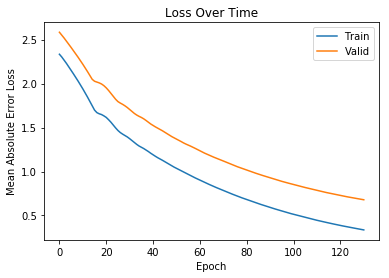

In [200]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error Loss')
plt.title('Loss Over Time')
plt.legend(['Train','Valid'])

In [201]:
test_pred = TCN.predict(test)
print(test_pred.shape)


(50, 20, 1)


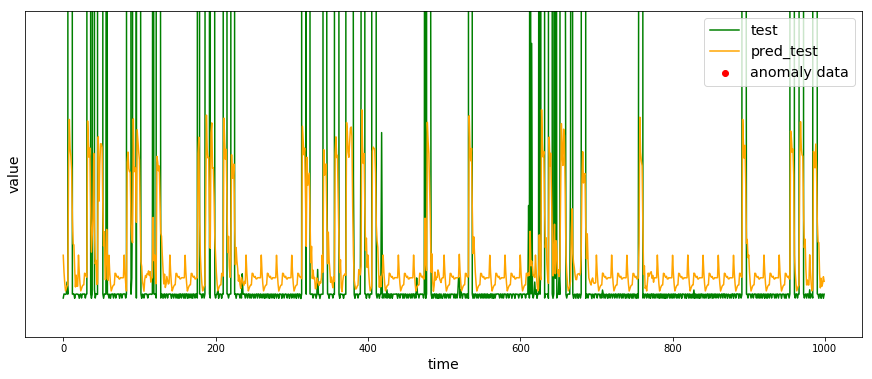

In [206]:
from matplotlib.pyplot import MultipleLocator
test1=test.reshape(test.shape[0]*test.shape[1],1)
test_pred1=test_pred.reshape(test_pred.shape[0]*test_pred.shape[1],1)
plt.figure(figsize=(15,6))
plt.xlabel('time',fontsize=14)
plt.ylabel('value',fontsize=14)
y_major_locator=MultipleLocator(10)
ax=plt.gca()
ax.yaxis.set_major_locator(y_major_locator)
plt.ylim(-0.4,-0.3)
plt.plot(test1[0:],color="green")
plt.plot(test_pred1[0:],color="orange",linestyle='-')
for i in range(len(test1)):
    if test_label[i] == 1:
        plt.scatter(i,test1[i],color="red")          
plt.legend(('test','pred_test','anomaly data'),loc='upper right',fontsize='x-large')


In [228]:
#点集检测
pred_label=[]
for i in range(len(test1)):
    pred_label.append(0)#正常

PAsum_rela_erro=np.zeros((len(pred_label)), dtype = float)
for i in range(len(pred_label)):
    PAsum_rela_erro[i]=np.abs(test1[i]-test_pred1[i])
PAscores=PAsum_rela_erro.copy()
PAscores.sort()
print(PAscores)


[2.30091957e-04 3.04904942e-04 7.18630336e-04 8.21672944e-04
 9.14542366e-04 9.19698168e-04 9.19698168e-04 9.20055795e-04
 9.20055795e-04 9.20055795e-04 9.20592237e-04 9.26195074e-04
 9.26284481e-04 9.27685190e-04 9.85990741e-04 9.86556985e-04
 9.91563776e-04 9.92189624e-04 9.92189624e-04 9.98895147e-04
 9.99222972e-04 9.99461391e-04 1.00008724e-03 1.00509403e-03
 1.03069422e-03 1.06739309e-03 1.07183364e-03 1.12572269e-03
 1.16363536e-03 1.35580664e-03 1.38401617e-03 1.47050469e-03
 1.65511248e-03 1.66565030e-03 1.67459099e-03 1.67524664e-03
 1.67548506e-03 1.67593210e-03 1.67834609e-03 1.67834609e-03
 1.67864411e-03 1.67864411e-03 1.68412774e-03 1.68460457e-03
 1.73336117e-03 1.73784373e-03 1.74240349e-03 1.74273131e-03
 1.74678443e-03 1.74708245e-03 1.74720166e-03 1.74735067e-03
 1.74749968e-03 1.74821494e-03 1.74946664e-03 1.74994347e-03
 1.75393698e-03 1.75498007e-03 1.79804442e-03 1.80967954e-03
 1.82204750e-03 1.84523909e-03 1.84705165e-03 1.99766038e-03
 2.00788364e-03 2.021016

In [229]:
print(PAscores[500])

0.005931745746162231


In [230]:
PAcutoff=int(0.87*len(PAscores))
PAthreshold=PAscores[PAcutoff]
print(PAscores[PAcutoff])

0.6308331016874731


In [231]:
for i in range(len(test1)):
    if PAsum_rela_erro[i] > PAthreshold:
        pred_label[i]=2 #异常

In [232]:
normal_rela_erro=0.15
#集体集检测
timestep=20
n=int(len(pred_label)/timestep)
CAsum_rela_erro=np.zeros(n+1, dtype = float)
for i in range(0,len(test1),timestep):
    for j in range(timestep):
            if ((i+j)<len(pred_label)) and (pred_label[i+j]==0):
                rela_erro=np.abs(test1[i+j]-test_pred1[i+j])
                CAsum_rela_erro[int(i/timestep)]=rela_erro+CAsum_rela_erro[int(i/timestep)]
              #  print()
            else:
                CAsum_rela_erro[int(i/timestep)]=normal_rela_erro+CAsum_rela_erro[int(i/timestep)]
                
                
CAscores=CAsum_rela_erro.copy()
CAscores.sort()
print(CAscores)


[0.         0.09935397 0.10174809 0.10202724 0.10291935 0.10320312
 0.10340185 0.1038954  0.10390419 0.10397135 0.10403216 0.10410394
 0.10417535 0.1041851  0.10423473 0.10437358 0.10522476 0.10528741
 0.10528849 0.10625202 0.10640085 0.269298   0.4126946  0.44715643
 0.52898329 0.70312964 0.71515539 0.71930134 0.72589148 0.73265007
 0.73506873 0.73731084 0.79261292 0.81202874 0.85539436 0.86122674
 0.8620771  0.94804807 0.99233995 0.99296733 1.06165187 1.17468668
 1.22242856 1.33155797 1.34649489 1.36111243 1.56605334 1.62185287
 2.27288777 2.2780546  2.28141557]


In [233]:
CAcutoff=int(0.99*len(CAscores))
CAthreshold=4#CAscores[CAcutoff]
print(CAthreshold)

4


In [234]:
for i in range(n+1):
    if CAsum_rela_erro[i] > CAthreshold:
        for j in range(timestep):
            if i*timestep+j<len(pred_label) and pred_label[i*timestep+j]!=2:
                pred_label[i*timestep+j]=1
        

In [235]:
Perro_x=[]
Perro_y=[]
Cerro_x=[]
Cerro_y=[]
for i in range(len(test1)):
    if pred_label[i]==2:
        Perro_x.append(i)
        Perro_y.append(test1[i])
    elif pred_label[i]==1:
        Cerro_x.append(i)
        Cerro_y.append(test1[i])

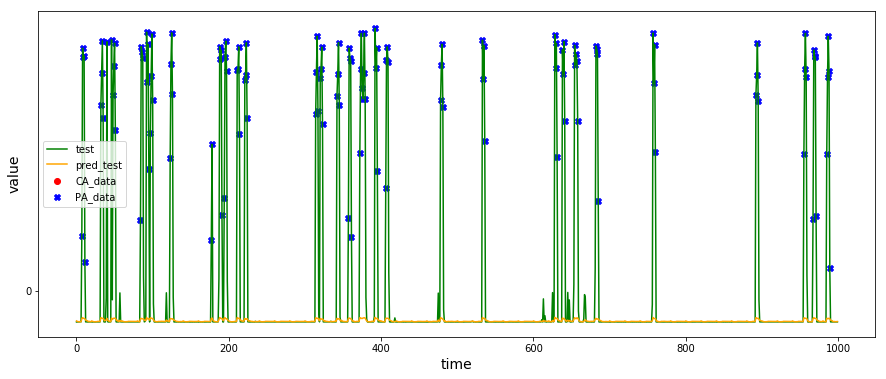

In [236]:
from matplotlib.pyplot import MultipleLocator
test1=test.reshape(test.shape[0]*test.shape[1],1)
test_pred1=test_pred.reshape(test_pred.shape[0]*test_pred.shape[1],1)
plt.figure(figsize=(15,6))
plt.xlabel('time',fontsize=14)
plt.ylabel('value',fontsize=14)
y_major_locator=MultipleLocator(100)
ax=plt.gca()
ax.yaxis.set_major_locator(y_major_locator)
#plt.ylim(0,1000)
plt.plot(test1[0:],color="green",label='test')
plt.plot(test_pred1[0:],color="orange",linestyle='-',label='pred_test')
plt.scatter(Cerro_x,Cerro_y,color="red",label='CA_data')
plt.scatter(Perro_x,Perro_y,color="blue",marker="X",label='PA_data')          
plt.legend()


In [237]:
Pred_label=[]
for i in range(len(pred_label)):
    if pred_label[i]==0:
        Pred_label.append(0)
    else:
        Pred_label.append(1)

In [238]:
print("CA:",pred_label.count(1))
print("PA:",pred_label.count(2))
ROC=roc_auc_score(test_label,Pred_label)
print("ROC_AUC score:{:2%}".format(ROC))  
precision, recall, _thresholds = precision_recall_curve(test_label, Pred_label)
PR_AUC = auc(recall, precision)
print("PR-AUC score:{:2%}".format(PR_AUC)) 

CA: 0
PA: 129
ROC_AUC score:99.885452%
PR-AUC score:99.224806%


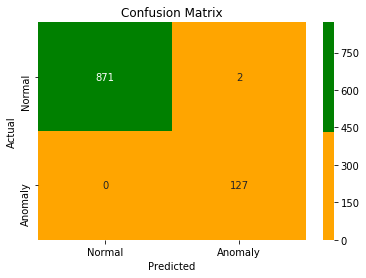

In [239]:
class Visualization:
    labels = ["Normal", "Anomaly"]

    def draw_confusion_matrix(self, y, ypred):
        matrix = confusion_matrix(y, ypred)

        plt.figure(figsize=(6, 4))
        colors=[ "orange","green"]
        sns.heatmap(matrix, xticklabels=self.labels, yticklabels=self.labels, cmap=colors, annot=True, fmt="d")
        plt.title("Confusion Matrix")
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        plt.show()

viz = Visualization()
viz.draw_confusion_matrix(test_label,Pred_label)